# phase 3: Incremental SFM


**Group 32**

**Members:**
- M. Walid Khalid (26100259)
- Sarmad Sultan (26100179)

---

## Initialization
Setup paths, and detection parameters

In [1]:
import cv2
import numpy as np
import os
from scipy.optimize import least_squares
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt

# Paths
IMAGE_DIR = './images'  # Change this to your image directory
NUM_IMAGES = 33  # Number of images to process. going with all of them


# SIFT parameters
SIFT_FEATURES = 5000
LOWE_RATIO = 0.7
RANSAC_THRESH = 1.0
RANSAC_CONFIDENCE = 0.999

PNP_RANSAC_ITER = 1000
PNP_REPROJ_ERROR = 8.0


## 1. Load Images and Extract SIFT Features
Load all images and detect SIFT keypoints and descriptors

In [3]:
image_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith(('.jpg', '.png', '.jpeg'))])[:NUM_IMAGES]
images = [cv2.imread(os.path.join(IMAGE_DIR, f)) for f in image_files]
images_gray = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]

IMAGE_HEIGHT, IMAGE_WIDTH = images[0].shape[:2]
fx = fy = 1.2 * max(IMAGE_WIDTH, IMAGE_HEIGHT)
cx = IMAGE_WIDTH / 2
cy = IMAGE_HEIGHT / 2
K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

sift = cv2.SIFT_create(SIFT_FEATURES)
keypoints_all = []
descriptors_all = []

for i, img_gray in enumerate(images_gray):
    kp, desc = sift.detectAndCompute(img_gray, None)
    keypoints_all.append(kp)
    descriptors_all.append(desc)
    print(f"Image {i}: {len(kp)} keypoints")

Image 0: 5000 keypoints
Image 1: 5000 keypoints
Image 1: 5000 keypoints
Image 2: 5000 keypoints
Image 2: 5000 keypoints
Image 3: 5000 keypoints
Image 3: 5000 keypoints
Image 4: 5000 keypoints
Image 4: 5000 keypoints
Image 5: 5000 keypoints
Image 5: 5000 keypoints
Image 6: 5001 keypoints
Image 6: 5001 keypoints
Image 7: 5000 keypoints
Image 7: 5000 keypoints
Image 8: 5000 keypoints
Image 8: 5000 keypoints
Image 9: 5001 keypoints
Image 9: 5001 keypoints
Image 10: 5001 keypoints
Image 10: 5001 keypoints
Image 11: 5000 keypoints
Image 11: 5000 keypoints
Image 12: 5001 keypoints
Image 12: 5001 keypoints
Image 13: 5000 keypoints
Image 13: 5000 keypoints
Image 14: 5000 keypoints
Image 14: 5000 keypoints
Image 15: 5000 keypoints
Image 15: 5000 keypoints
Image 16: 5000 keypoints
Image 16: 5000 keypoints
Image 17: 5000 keypoints
Image 17: 5000 keypoints
Image 18: 5000 keypoints
Image 18: 5000 keypoints
Image 19: 5000 keypoints
Image 19: 5000 keypoints
Image 20: 5000 keypoints
Image 20: 5000 keyp

## 2. Phase 1: Two-View Reconstruction
Initialize with first two images using Essential Matrix decomposition

In [4]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors_all[0], descriptors_all[1], k=2)

good_matches = []
for m, n in matches:
    if m.distance < LOWE_RATIO * n.distance:
        good_matches.append(m)

pts1 = np.float32([keypoints_all[0][m.queryIdx].pt for m in good_matches])
pts2 = np.float32([keypoints_all[1][m.trainIdx].pt for m in good_matches])

print(f"Found {len(good_matches)} good matches")

E, mask_e = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, 
                                  prob=RANSAC_CONFIDENCE, threshold=RANSAC_THRESH)
pts1 = pts1[mask_e.ravel() == 1]
pts2 = pts2[mask_e.ravel() == 1]

_, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2, K)
pts1 = pts1[mask_pose.ravel() > 0]
pts2 = pts2[mask_pose.ravel() > 0]

print(f"Inliers after pose recovery: {len(pts1)}")

Found 1724 good matches
Inliers after pose recovery: 1061


## 3. Triangulate Initial 3D Points
Convert 2D correspondences to 3D points using triangulation

In [5]:
P1 = K @ np.hstack([np.eye(3), np.zeros((3, 1))])
P2 = K @ np.hstack([R, t])

points_4d = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
points_3d = (points_4d[:3] / points_4d[3]).T

# cheirality check 
def is_in_front(points_3d, R, t):
    points_cam = (R @ points_3d.T).T + t.ravel()
    return points_cam[:, 2] > 0

mask_front1 = points_3d[:, 2] > 0
mask_front2 = is_in_front(points_3d, R, t)
mask_valid = mask_front1 & mask_front2

points_3d = points_3d[mask_valid]
pts1 = pts1[mask_valid]
pts2 = pts2[mask_valid]

print(f"Valid 3D points after cheirality check: {len(points_3d)}")

Valid 3D points after cheirality check: 1061


## 4. Initialize Reconstruction Data Structures
Setup tracking for cameras, 3D points, and visibility

In [6]:
camera_poses = [
    np.hstack([np.eye(3), np.zeros((3, 1))]),  # Camera 0
    np.hstack([R, t])  # Camera 1
]

points_3d_global = points_3d.copy()


point_observations = {}
for i in range(len(points_3d)):
    point_observations[i] = [(0, pts1[i]), (1, pts2[i])]

keypoint_to_3d = [np.full(len(kp), -1) for kp in keypoints_all]

match_indices_0 = [m.queryIdx for m in good_matches]
match_indices_1 = [m.trainIdx for m in good_matches]
match_indices_0 = np.array(match_indices_0)[mask_e.ravel() == 1][mask_pose.ravel() > 0][mask_valid]
match_indices_1 = np.array(match_indices_1)[mask_e.ravel() == 1][mask_pose.ravel() > 0][mask_valid]

for i, (idx0, idx1) in enumerate(zip(match_indices_0, match_indices_1)):
    keypoint_to_3d[0][idx0] = i
    keypoint_to_3d[1][idx1] = i

print(f"Initialized reconstruction with {len(camera_poses)} cameras and {len(points_3d_global)} 3D points")

Initialized reconstruction with 2 cameras and 1061 3D points


## 5. Incremental Reconstruction
Add remaining cameras using PnP and triangulate new points

In [7]:
for cam_idx in range(2, len(images)):
    print(f"\n--- Processing Camera {cam_idx} ---")
    
    points_2d = []
    points_3d_idx = []
    
    for prev_cam_idx in range(cam_idx):
        matches = bf.knnMatch(descriptors_all[cam_idx], descriptors_all[prev_cam_idx], k=2)
        
        for m, n in matches:
            if m.distance < LOWE_RATIO * n.distance:
                curr_kp_idx = m.queryIdx
                prev_kp_idx = m.trainIdx
                
                point_3d_idx = keypoint_to_3d[prev_cam_idx][prev_kp_idx]
                if point_3d_idx >= 0:
                    points_2d.append(keypoints_all[cam_idx][curr_kp_idx].pt)
                    points_3d_idx.append(point_3d_idx)
    
    if len(points_2d) < 6:
        print(f"Not enough 2D-3D correspondences: {len(points_2d)}")
        break
    
    points_2d = np.array(points_2d, dtype=np.float32)
    points_3d_for_pnp = points_3d_global[points_3d_idx]
    
    print(f"Found {len(points_2d)} 2D-3D correspondences")
    
    success, rvec, tvec, inliers = cv2.solvePnPRansac(
        points_3d_for_pnp, points_2d, K, None,
        iterationsCount=PNP_RANSAC_ITER,
        reprojectionError=PNP_REPROJ_ERROR,
        confidence=RANSAC_CONFIDENCE
    )
    
    if not success:
        print("PnP failed")
        break
    
    R_new, _ = cv2.Rodrigues(rvec)
    t_new = tvec
    camera_poses.append(np.hstack([R_new, t_new]))
    
    print(f"PnP inliers: {len(inliers)} / {len(points_2d)}")
    
    inliers_flat = inliers.ravel()
    for inlier_idx in inliers_flat:
        pt_3d_idx = points_3d_idx[inlier_idx]
        pt_2d = points_2d[inlier_idx]
        point_observations[pt_3d_idx].append((cam_idx, pt_2d))
    
    # triangulate new points with previous camera
    prev_cam_idx = cam_idx - 1
    matches = bf.knnMatch(descriptors_all[cam_idx], descriptors_all[prev_cam_idx], k=2)
    
    new_pts_curr = []
    new_pts_prev = []
    new_kp_idx_curr = []
    new_kp_idx_prev = []
    
    for m, n in matches:
        if m.distance < LOWE_RATIO * n.distance:
            curr_kp_idx = m.queryIdx
            prev_kp_idx = m.trainIdx
            
            # only triangulate if neither point has a 3D correspondence yet
            if keypoint_to_3d[cam_idx][curr_kp_idx] == -1 and keypoint_to_3d[prev_cam_idx][prev_kp_idx] == -1:
                new_pts_curr.append(keypoints_all[cam_idx][curr_kp_idx].pt)
                new_pts_prev.append(keypoints_all[prev_cam_idx][prev_kp_idx].pt)
                new_kp_idx_curr.append(curr_kp_idx)
                new_kp_idx_prev.append(prev_kp_idx)
    
    if len(new_pts_curr) > 0:
        new_pts_curr = np.array(new_pts_curr, dtype=np.float32)
        new_pts_prev = np.array(new_pts_prev, dtype=np.float32)
        
        P_prev = K @ camera_poses[prev_cam_idx]
        P_curr = K @ camera_poses[cam_idx]
        
        points_4d_new = cv2.triangulatePoints(P_prev, P_curr, new_pts_prev.T, new_pts_curr.T)
        points_3d_new = (points_4d_new[:3] / points_4d_new[3]).T
        
        # cheirality check
        R_prev = camera_poses[prev_cam_idx][:, :3]
        t_prev = camera_poses[prev_cam_idx][:, 3:]
        R_curr = camera_poses[cam_idx][:, :3]
        t_curr = camera_poses[cam_idx][:, 3:]
        
        mask_front_prev = is_in_front(points_3d_new, R_prev, t_prev)
        mask_front_curr = is_in_front(points_3d_new, R_curr, t_curr)
        mask_valid_new = mask_front_prev & mask_front_curr
        
        valid_count = 0
        for i, valid in enumerate(mask_valid_new):
            if valid:
                new_pt_idx = len(points_3d_global)
                points_3d_global = np.vstack([points_3d_global, points_3d_new[i]])
                
                point_observations[new_pt_idx] = [
                    (prev_cam_idx, new_pts_prev[i]),
                    (cam_idx, new_pts_curr[i])
                ]
                
                keypoint_to_3d[prev_cam_idx][new_kp_idx_prev[i]] = new_pt_idx
                keypoint_to_3d[cam_idx][new_kp_idx_curr[i]] = new_pt_idx
                valid_count += 1
        
        print(f"Triangulated {valid_count} new 3D points")
    
    print(f"Total: {len(camera_poses)} cameras, {len(points_3d_global)} 3D points")

print(f"\n=== Incremental reconstruction complete ===")
print(f"Final: {len(camera_poses)} cameras, {len(points_3d_global)} 3D points")


--- Processing Camera 2 ---
Found 661 2D-3D correspondences
PnP inliers: 451 / 661
Triangulated 755 new 3D points
Total: 3 cameras, 1816 3D points

--- Processing Camera 3 ---
Triangulated 755 new 3D points
Total: 3 cameras, 1816 3D points

--- Processing Camera 3 ---
Found 1185 2D-3D correspondences
PnP inliers: 672 / 1185
Triangulated 964 new 3D points
Total: 4 cameras, 2780 3D points

--- Processing Camera 4 ---
Found 1185 2D-3D correspondences
PnP inliers: 672 / 1185
Triangulated 964 new 3D points
Total: 4 cameras, 2780 3D points

--- Processing Camera 4 ---
Found 959 2D-3D correspondences
PnP inliers: 315 / 959
Triangulated 490 new 3D points
Total: 5 cameras, 3270 3D points

--- Processing Camera 5 ---
Found 959 2D-3D correspondences
PnP inliers: 315 / 959
Triangulated 490 new 3D points
Total: 5 cameras, 3270 3D points

--- Processing Camera 5 ---
Found 1942 2D-3D correspondences
PnP inliers: 950 / 1942
Triangulated 609 new 3D points
Total: 6 cameras, 3879 3D points

--- Processi

## 6. Save Initial Reconstruction
Export point cloud before bundle adjustment

In [8]:
def save_ply(filename, points_3d, colors=None):
    with open(filename, 'w') as f:
        f.write('ply\n')
        f.write('format ascii 1.0\n')
        f.write(f'element vertex {len(points_3d)}\n')
        f.write('property float x\n')
        f.write('property float y\n')
        f.write('property float z\n')
        if colors is not None:
            f.write('property uchar red\n')
            f.write('property uchar green\n')
            f.write('property uchar blue\n')
        f.write('end_header\n')
        
        for i, pt in enumerate(points_3d):
            if colors is not None:
                f.write(f'{pt[0]} {pt[1]} {pt[2]} {colors[i][0]} {colors[i][1]} {colors[i][2]}\n')
            else:
                f.write(f'{pt[0]} {pt[1]} {pt[2]}\n')

save_ply('reconstruction_initial.ply', points_3d_global)
print("Saved reconstruction_initial.ply")

Saved reconstruction_initial.ply


## 7. Bundle Adjustment - Optimization Setup
Define reprojection error and prepare optimization parameters

In [9]:
def project_points(points_3d, camera_pose, K):

    R = camera_pose[:, :3]
    t = camera_pose[:, 3:]
    points_cam = (R @ points_3d.T).T + t.T
    points_proj = (K @ points_cam.T).T
    points_2d = points_proj[:, :2] / points_proj[:, 2:3]
    return points_2d

def reprojection_residuals(params, n_cameras, n_points, camera_indices, point_indices, points_2d, K):
    
    camera_params = params[:n_cameras * 6].reshape((n_cameras, 6))
    points_3d = params[n_cameras * 6:].reshape((n_points, 3))
    
    residuals = []
    for i, (cam_idx, pt_idx) in enumerate(zip(camera_indices, point_indices)):

        rvec = camera_params[cam_idx, :3]
        tvec = camera_params[cam_idx, 3:]
        R, _ = cv2.Rodrigues(rvec)
        t = tvec.reshape(3, 1)
        camera_pose = np.hstack([R, t])
        
        point_3d = points_3d[pt_idx:pt_idx+1]
        point_2d_proj = project_points(point_3d, camera_pose, K)
        
        residual = points_2d[i] - point_2d_proj[0]
        residuals.extend(residual)
    
    return np.array(residuals)

# prepare data for bundle adjustment
camera_indices = []
point_indices = []
points_2d_obs = []

for pt_idx, observations in point_observations.items():
    for cam_idx, pt_2d in observations:
        camera_indices.append(cam_idx)
        point_indices.append(pt_idx)
        points_2d_obs.append(pt_2d)

camera_indices = np.array(camera_indices)
point_indices = np.array(point_indices)
points_2d_obs = np.array(points_2d_obs)

print(f"Observations for BA: {len(camera_indices)}")
print(f"Cameras: {len(camera_poses)}, Points: {len(points_3d_global)}")

Observations for BA: 33509
Cameras: 27, Points: 12712


## 8. Compute Initial Reprojection Error
Calculate mean reprojection error before optimization

In [10]:
camera_params_init = []
for pose in camera_poses:
    R = pose[:, :3]
    t = pose[:, 3:]
    rvec, _ = cv2.Rodrigues(R)
    camera_params_init.append(np.concatenate([rvec.ravel(), t.ravel()]))

camera_params_init = np.array(camera_params_init)
x0 = np.hstack([camera_params_init.ravel(), points_3d_global.ravel()])

residuals_init = reprojection_residuals(
    x0, len(camera_poses), len(points_3d_global),
    camera_indices, point_indices, points_2d_obs, K
)
initial_error = np.mean(np.abs(residuals_init))
print(f"Initial mean reprojection error: {initial_error:.4f} pixels")

Initial mean reprojection error: 54.6740 pixels


## 9. Run Bundle Adjustment
Optimize all camera poses and 3D points simultaneously

In [17]:
# sparsity becuase bundle adjustment Jacobian was getting stuck with too many parameters
from scipy.sparse import lil_matrix

def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    m = len(camera_indices) * 2  # number of residuals
    n = n_cameras * 6 + n_points * 3  # number of parameters
    A = lil_matrix((m, n), dtype=int)
    
    i = np.arange(len(camera_indices))
    for s in range(6):
        A[2 * i, camera_indices * 6 + s] = 1
        A[2 * i + 1, camera_indices * 6 + s] = 1
    
    for s in range(3):
        A[2 * i, n_cameras * 6 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 6 + point_indices * 3 + s] = 1
    
    return A

A = bundle_adjustment_sparsity(len(camera_poses), len(points_3d_global), camera_indices, point_indices)

result = least_squares(
    reprojection_residuals,
    x0,
    jac_sparsity=A,  
    args=(len(camera_poses), len(points_3d_global), camera_indices, point_indices, points_2d_obs, K),
    verbose=2,
    max_nfev=100,
    method='trf',
    ftol=1e-8,      # Cost function tolerance
    xtol=None,      # Parameter tolerance  
    gtol=None      # Gradient tolerance 
)
print(f"\nBundle adjustment completed")
print(f"Success: {result.success}")
print(f"Iterations: {result.nfev}")

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0487e+10                                    2.09e+13    
       1              2         1.9432e+10      1.06e+09       9.78e-01       8.18e+12    
       1              2         1.9432e+10      1.06e+09       9.78e-01       8.18e+12    
       2              3         4.6138e+09      1.48e+10       3.71e-02       9.41e+11    
       2              3         4.6138e+09      1.48e+10       3.71e-02       9.41e+11    
       3              4         1.2371e+09      3.38e+09       7.06e-02       1.02e+11    
       3              4         1.2371e+09      3.38e+09       7.06e-02       1.02e+11    
       4              5         4.1222e+08      8.25e+08       1.33e-01       1.30e+10    
       4              5         4.1222e+08      8.25e+08       1.33e-01       1.30e+10    
       5              7         3.9336e+08      1.89e+07       6.11e-02       5.07e+10    

## 10. Extract and Save Refined Parameters
Update camera poses and 3D points from optimization result

In [20]:
# Extract optimized parameters
n_cameras = len(camera_poses)
n_points = len(points_3d_global)
camera_params_opt = result.x[:n_cameras * 6].reshape((n_cameras, 6))
points_3d_opt = result.x[n_cameras * 6:].reshape((n_points, 3))

# Update camera poses
camera_poses_refined = []
for i in range(n_cameras):
    rvec = camera_params_opt[i, :3]
    tvec = camera_params_opt[i, 3:]
    R, _ = cv2.Rodrigues(rvec)
    t = tvec.reshape(3, 1)
    camera_poses_refined.append(np.hstack([R, t]))

# Compute final error
residuals_final = reprojection_residuals(
    result.x, n_cameras, n_points,
    camera_indices, point_indices, points_2d_obs, K
)
final_error = np.mean(np.abs(residuals_final))

print(f"\n=== Bundle Adjustment Results ===")
print(f"Cameras: {n_cameras}")
print(f"3D Points: {n_points}")
print(f"Observations: {len(camera_indices)}")
print(f"Initial mean reprojection error: {initial_error:.4f} pixels")
print(f"Final mean reprojection error: {final_error:.4f} pixels")
print(f"Improvement: {initial_error - final_error:.4f} pixels ({(1 - final_error/initial_error)*100:.2f}%)")


=== Bundle Adjustment Results ===
Cameras: 27
3D Points: 12712
Observations: 33509
Initial mean reprojection error: 54.6740 pixels
Final mean reprojection error: 21.2998 pixels
Improvement: 33.3742 pixels (61.04%)


In [21]:
save_ply('reconstruction_refined.ply', points_3d_opt)
print("Saved reconstruction_refined.ply")
print("\nReconstruction complete! View .ply files in MeshLab or CloudCompare")

Saved reconstruction_refined.ply

Reconstruction complete! View .ply files in MeshLab or CloudCompare


## 11. Visualization
Plot camera positions before and after bundle adjustment

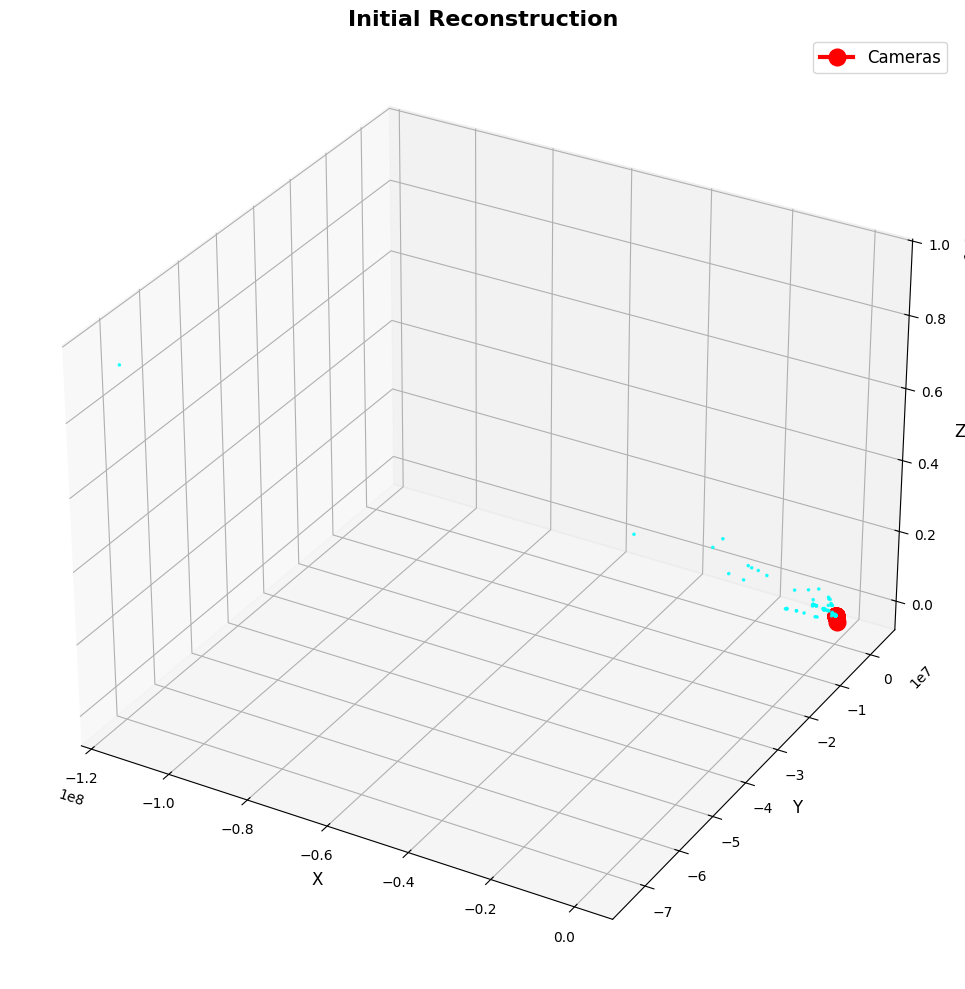

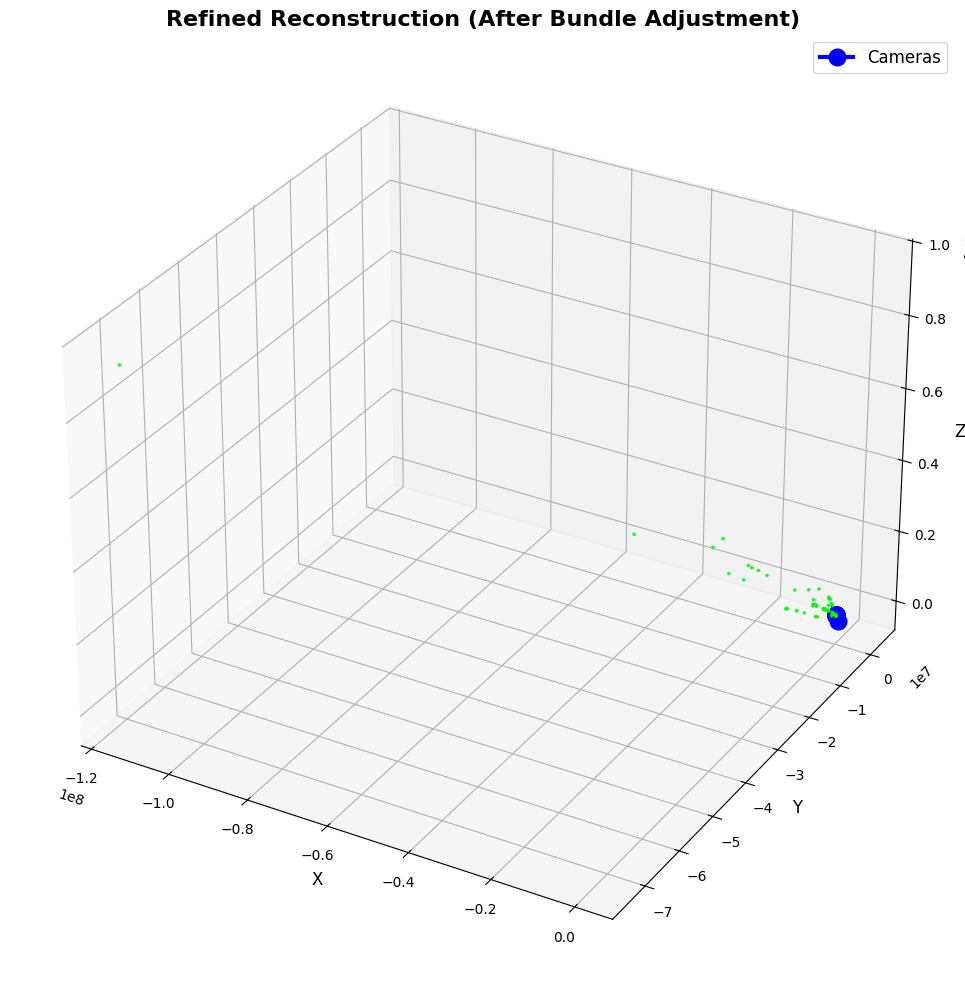

In [23]:
# Extract camera centers
camera_centers_init = []
camera_centers_refined = []

for i in range(len(camera_poses)):
    R_init = camera_poses[i][:, :3]
    t_init = camera_poses[i][:, 3:]
    C_init = -R_init.T @ t_init
    camera_centers_init.append(C_init.ravel())
    
    R_refined = camera_poses_refined[i][:, :3]
    t_refined = camera_poses_refined[i][:, 3:]
    C_refined = -R_refined.T @ t_refined
    camera_centers_refined.append(C_refined.ravel())

camera_centers_init = np.array(camera_centers_init)
camera_centers_refined = np.array(camera_centers_refined)

# Plot Initial Reconstruction
fig1 = plt.figure(figsize=(12, 10))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.scatter(points_3d_global[:, 0], points_3d_global[:, 1], points_3d_global[:, 2], 
            c='cyan', marker='.', s=10, alpha=0.8)
ax1.plot(camera_centers_init[:, 0], camera_centers_init[:, 1], camera_centers_init[:, 2], 
         'ro-', markersize=12, linewidth=3, label='Cameras')
ax1.set_title('Initial Reconstruction', fontsize=16, fontweight='bold')
ax1.set_xlabel('X', fontsize=12)
ax1.set_ylabel('Y', fontsize=12)
ax1.set_zlabel('Z', fontsize=12)
ax1.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plot Refined Reconstruction
fig2 = plt.figure(figsize=(12, 10))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.scatter(points_3d_opt[:, 0], points_3d_opt[:, 1], points_3d_opt[:, 2], 
            c='lime', marker='.', s=10, alpha=0.8)
ax2.plot(camera_centers_refined[:, 0], camera_centers_refined[:, 1], camera_centers_refined[:, 2], 
         'bo-', markersize=12, linewidth=3, label='Cameras')
ax2.set_title('Refined Reconstruction (After Bundle Adjustment)', fontsize=16, fontweight='bold')
ax2.set_xlabel('X', fontsize=12)
ax2.set_ylabel('Y', fontsize=12)
ax2.set_zlabel('Z', fontsize=12)
ax2.legend(fontsize=12)
plt.tight_layout()
plt.show()


## 12. Open3D Interactive Visualization
Visualize the refined 3D reconstruction with camera poses

In [24]:
import open3d as o3d

# Load the refined point cloud
pcd = o3d.io.read_point_cloud('reconstruction_refined.ply')
print(f"Loaded {len(pcd.points)} points")

# Color the point cloud (uniform color if no colors in file)
if not pcd.has_colors():
    pcd.paint_uniform_color([0.5, 0.5, 0.5])

# Create camera frustums for visualization
camera_geometries = []
for i, pose in enumerate(camera_poses_refined):
    R = pose[:, :3]
    t = pose[:, 3:]
    C = -R.T @ t  # Camera center
    
    # Create a small sphere at camera position
    sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.5)
    sphere.paint_uniform_color([1, 0, 0])  # Red for cameras
    sphere.translate(C.ravel())
    camera_geometries.append(sphere)
    
    # Create camera frustum
    frustum_length = 2.0
    frustum = o3d.geometry.LineSet()
    
    # Frustum points in camera frame
    points = np.array([
        [0, 0, 0],  # Camera center
        [-1, -1, frustum_length],  # Bottom-left
        [1, -1, frustum_length],   # Bottom-right
        [1, 1, frustum_length],    # Top-right
        [-1, 1, frustum_length]    # Top-left
    ])
    
    # Transform to world frame
    points_world = (R @ points.T).T + C.T
    
    # Define lines connecting frustum points
    lines = np.array([
        [0, 1], [0, 2], [0, 3], [0, 4],  # Camera center to corners
        [1, 2], [2, 3], [3, 4], [4, 1]   # Rectangle at image plane
    ])
    
    frustum.points = o3d.utility.Vector3dVector(points_world)
    frustum.lines = o3d.utility.Vector2iVector(lines)
    frustum.paint_uniform_color([0, 0, 1])  # Blue for frustums
    camera_geometries.append(frustum)

# Create coordinate frame at origin
coord_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=5.0, origin=[0, 0, 0])

# Visualize
print("\n=== Opening Open3D Visualization ===")
print("Controls:")
print("  - Mouse: Rotate view")
print("  - Scroll: Zoom in/out")
print("  - Ctrl + Mouse: Pan")
print("  - Press 'H' for help")
print("  - Press 'Q' or close window to exit")

o3d.visualization.draw_geometries(
    [pcd, coord_frame] + camera_geometries,
    window_name="3D Reconstruction - Refined",
    width=1280,
    height=720,
    point_show_normal=False
)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Loaded 12712 points

=== Opening Open3D Visualization ===
Controls:
  - Mouse: Rotate view
  - Scroll: Zoom in/out
  - Ctrl + Mouse: Pan
  - Press 'H' for help
  - Press 'Q' or close window to exit
